<a href="https://colab.research.google.com/github/adeepH/DravidianOffensive/blob/main/Notebooks/Transliterated/Tamil/mBERT_cased%2BbiLSTM_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 19.7MB/s 
     |████████████████████████████████| 1.2MB 46.8MB/s 
     |████████████████████████████████| 901kB 49.6MB/s 
     |████████████████████████████████| 3.0MB 48.8MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
train=pd.read_csv('/content/Trans_tam_train.csv')
train['labels']=LabelEncoder().fit_transform(train['label'])
train['tweets']=train['transliterated']
for i in range(len(train)):
  train['tweets'][i]=train['tweets'][i][8:-2]
train=train.drop(columns=['label','Unnamed: 0','transliterated','Sentence'])
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,labels,tweets
0,0,மோவி வேற லிவல் லா எரிகா பொகுது
1,5,ஐஸ் லோவ் அஜித் குமார் விவேகம் மோவி இங்கி மேஜி ...
2,0,படம் நல்ல காமெடி படாம இருகும் போலை..
3,0,கார்த்திக் சுப்பராஜ் அன்னி .... இந்த படம் வெற்...
4,0,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁
...,...,...
35134,0,டிராண்டிங் நம்பர் #2 இதுக்கு நம்மலம் காரணம்நு ...
35135,0,"மோவி ஸ்கிரிப்ட் சூப்பர், அதுவும் ஹிப் ஹாப் தமி..."
35136,0,ஜஸ்ட் 3கி லிக்ஸ் போர் 300கி லிக்ஸ்
35137,5,ஆலோ லே லோ. கண்டா லே லோ.


In [4]:
val=pd.read_csv('/content/Trans_tam_test.csv')
val['labels']=LabelEncoder().fit_transform(val['label'])
val['tweets']=val['transliterated']
for i in range(len(val)):
  val['tweets'][i]=val['tweets'][i][8:-2]
val=val.drop(columns=['label','Unnamed: 0','transliterated','Sentence'])
val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,labels,tweets
0,0,14.12.2018 எபோ டிரைலர் பதுது இர்கின் ... சேமாய...
1,0,பாகா தான போரோ மோவி லா எண்ணா இருகுணுணு
2,5,“யூ கேனா துங்கு லெபி லாமா லாகி உண்டுக் தவு சாய...
3,0,சூரிய அன்ன வேற லிவல் அன்ன மாஸ்
4,4,சூமா கத்தாத டா சவுண்ட் ஓவர் அம் பூடா குடாது பா...
...,...,...
4387,1,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...
4388,5,பாபு மேல் கோ ஐஸ் சாங் சுன்பே குச் எஷா பீல் ஹூவ...
4389,0,அசுரான்= ஆடுகலம்+புடுபெட்டை+ வாதா சென்னை..எல்ல...
4390,0,விஜய்'ஸ் ஆல் மோவிஸ் லோக் லிக் சேம்.


In [5]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [6]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (35139, 2)
validation set size: (4392, 2)


In [7]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([ 0.23034415,  2.29037935,  2.4995732 , 12.89977974,  2.01531315,
        4.0278542 ])

In [8]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [9]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [10]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-cased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [13]:
model = RFClassifier(6)
model = model.to(device)

In [14]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-uncased.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01 | Epoch Time: 14m 52s
Train Loss 0.9482143346806674 accuracy 0.7253194456302114
Val Loss 0.7957333073667858 accuracy 0.7388433515482696

Epoch: 02 | Epoch Time: 15m 0s
Train Loss 0.7593446231029378 accuracy 0.7491675915649278
Val Loss 0.758241914536642 accuracy 0.7534153005464481

Epoch: 03 | Epoch Time: 15m 0s
Train Loss 0.6883731451465175 accuracy 0.7653888841458208
Val Loss 0.7319474155488221 accuracy 0.7575136612021858

Epoch: 04 | Epoch Time: 15m 1s
Train Loss 0.6280430655543429 accuracy 0.7819801360311904
Val Loss 0.7315607098997503 accuracy 0.76183970856102

Epoch: 05 | Epoch Time: 15m 1s
Train Loss 0.5828904208809381 accuracy 0.7958678391530778
Val Loss 0.751956060744714 accuracy 0.7647996357012751



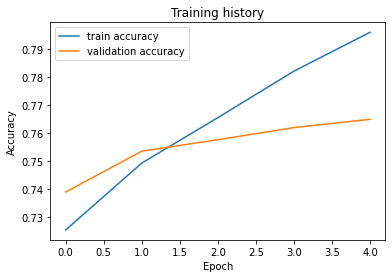

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [20]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.7647996357012751

In [21]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [22]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred,zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.8406    0.9473    0.8908      3190
           1     0.1739    0.0278    0.0479       288
           2     0.3382    0.2222    0.2682       315
           3     0.0000    0.0000    0.0000        71
           4     0.3692    0.4103    0.3887       368
           5     0.8000    0.6750    0.7322       160

    accuracy                         0.7648      4392
   macro avg     0.4203    0.3804    0.3880      4392
weighted avg     0.7063    0.7648    0.7286      4392

